In [1]:
import dolfinx as dlx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from eikonax import preprocessing, solver, tensorfield
from ls_prior import builder
from mpi4py import MPI

from cardiac_electrophysiology import data_processing as dp
from cardiac_electrophysiology import fiberfield

sns.set_theme(style="ticks")

In [2]:
mesh = dlx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([1, 1])],
    [20, 20],
    dlx.mesh.CellType.triangle,
)
vertices = mesh.geometry.x[:, :2]
simplices = mesh.geometry.dofmap
num_simplices = simplices.shape[0]
simplex_to_vertex_matrix = dp.assemble_simplex_to_vertex_interpolation_matrix(simplices)
vertex_to_simplex_matrix = dp.assemble_vertex_to_simplex_interpolation_matrix(simplices)

num_samples = 1000
mean_angle_vector = np.full(simplices.shape[0], 1 / 4 * np.pi)
mean_angle_vector = simplex_to_vertex_matrix @ mean_angle_vector
mean_parameter_vector = np.arctanh(np.cos(mean_angle_vector + np.pi / 2))
first_basis_vector = np.repeat([[1, 0]], num_simplices, axis=0)
second_basis_vector = np.repeat([[0, 1]], num_simplices, axis=0)
longitudinal_velocity_vector = np.full(num_simplices, 5)
transverse_velocity_vector = np.full(num_simplices, 1)

In [3]:
prior_settings = builder.BilaplacianPriorSettings(
    mesh=mesh,
    mean_vector=mean_parameter_vector,
    kappa=50,
    tau=0.05,
    seed=0,
)
prior_builder = builder.BilaplacianPriorBuilder(prior_settings)
bilaplace_prior = prior_builder.build()

fiber_tensor = fiberfield.FiberTensor(
    dimension=2,
    mean_angle_vector=mean_angle_vector,
    basis_vectors=[first_basis_vector, second_basis_vector],
    conduction_velocities=[longitudinal_velocity_vector, transverse_velocity_vector],
)
tensor_field_mapping = tensorfield.LinearScalarMap()
tensor_field_object = tensorfield.TensorField(
    num_simplices=num_simplices,
    vector_to_simplices_map=tensor_field_mapping,
    simplex_tensor=fiber_tensor,
)

solver_data = solver.SolverData(
    tolerance=1e-6,
    max_num_iterations=1000,
    max_value=1000,
    loop_type="jitted_while",
    use_soft_update=False,
    softminmax_order=20,
    softminmax_cutoff=0.01,
)
initial_site_ind = np.where((vertices[:,0] == 0) & (vertices[:,1] == 0))[0][0]
initial_sites = preprocessing.InitialSites(inds=(initial_site_ind,), values=(0,))
mesh_data = preprocessing.MeshData(mesh.geometry.x[:, :2], mesh.geometry.dofmap)
eikonal_solver = solver.Solver(mesh_data, solver_data, initial_sites)

In [4]:
solution_samples = []
for _ in range(num_samples):
    parameter_sample = bilaplace_prior.generate_sample()
    parameter_sample = vertex_to_simplex_matrix @ parameter_sample
    tensor_field_instance = tensor_field_object.assemble_field(parameter_sample)
    solution = eikonal_solver.run(tensor_field_instance)
    solution_values = np.array(solution.values)
    solution_samples.append(solution_values)

solution_samples = np.array(solution_samples).T
solution_mean = np.mean(solution_samples, axis=1)
solution_std = np.std(solution_samples, axis=1)

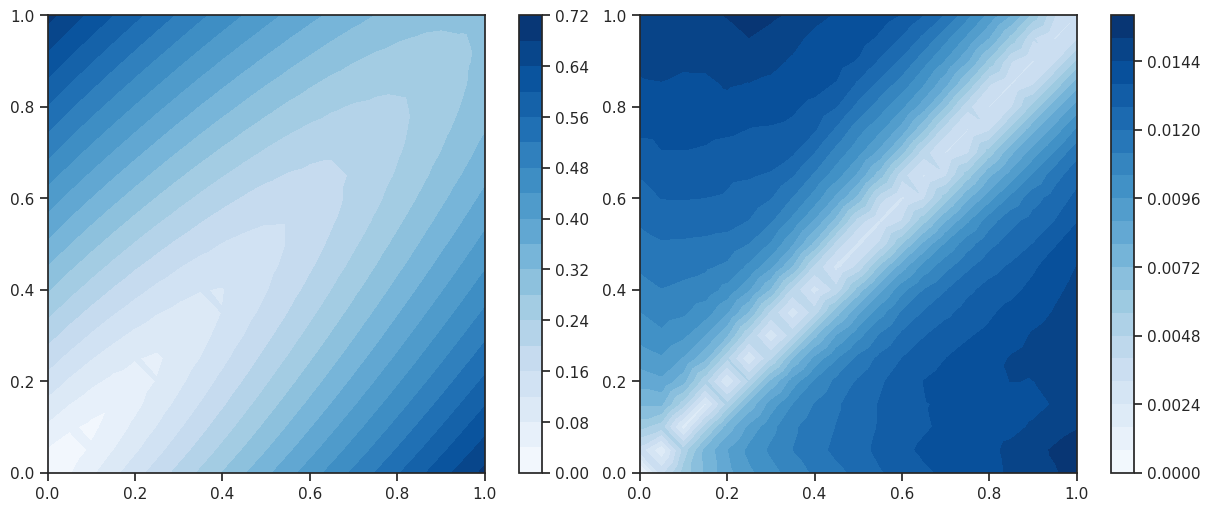

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), layout="constrained")
contour_plot = axs[0].tricontourf(
    vertices[:, 0], vertices[:, 1], solution_mean, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[0])
contour_plot = axs[1].tricontourf(
    vertices[:, 0], vertices[:, 1], solution_std, levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[1])